<a href="https://colab.research.google.com/github/AliAlBadra/KerasTFImageClassificationCNN/blob/main/EffNet_Inception_DenseNet_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install patchify
!pip install scikit-learn==1.0.0
!pip install split-folders
!pip install gast==0.3.2
!pip install six==1.15.0
!pip install folium==0.2.1
!pip install imgaug==0.2.5
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 50 kB 4.4 MB/s 
     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 448 kB 46.6 MB/s 
     |████████████████████████████████| 3.8 MB 34.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=42592f902b6f230e14be9cd80b5b116b21206407cccfa8ac4763af417fe41565
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

     |████████████████████████████████| 377 kB 5.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


     |████████████████████████████████| 23.1 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Created wheel for gast: filename=gast-0.3.2-py3-none-any.whl size=9694 sha256=1a24128eaf402b3542ec4224e6964d0f76ab3fc583cd3adaf5596e2449d162d0
  Stored in directory: /root/.cache/pip/wheels/9b/7b/89/365a82e420c11db9b43d34918045faa8004748a1d97597930d
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.1.0 requires gast==0.2.2, but you have gast 0.3.2 which is incompatible.


     |████████████████████████████████| 69 kB 3.6 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=1bbd83c12fb74312108f53dd7d19607b07d57bb315aaa566d3da8b629289de7f
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 562 kB 5.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=3ee8c5ae0ca3460cffbb5dfaef53a150cf5713e6bc1f04fd02b697208a6cb789
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |██████████

In [1]:
cellseg_dir = '/content/drive/MyDrive/CellSeg/'
data_dir = cellseg_dir + "data/"
input_dir = data_dir + "input/"
original_input_dir = input_dir + "original/"
after_patchify_384_input_dir = input_dir + "after_patchify_384/"
after_patchify_256_input_dir = input_dir + "after_patchify_256/"
output_dir = data_dir + "output/"

In [2]:
# https://youtu.be/F365vQ8EndQ
"""
Author: Sreenivas Bhattiprolu

Multiclass semantic segmentation using U-Net with VGG, ResNet, and Inception 
as backbones

Segmentation models: https://github.com/qubvel/segmentation_models

To annotate images and generate labels, you can use APEER (for free):
www.apeer.com 
"""

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU


#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob(after_patchify_256_input_dir + "images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(after_patchify_256_input_dir + "masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [4]:
#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [5]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1]


In [7]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
########################################################################
###Model 1
BACKBONE1 = 'efficientnetb4'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [12]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model1.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

71892992/71892840 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
___________________________

In [13]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=4, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

model1.save(cellseg_dir + 'model/full/EffNetB4_backbone_50epochs.hdf5')

Train on 340 samples, validate on 76 samples
Epoch 1/50
340/340 [==============================] - 80s 235ms/sample - loss: 0.4708 - iou_score: 0.5764 - val_loss: 0.6058 - val_iou_score: 0.6725
Epoch 2/50
340/340 [==============================] - 50s 146ms/sample - loss: 0.2918 - iou_score: 0.7530 - val_loss: 0.4549 - val_iou_score: 0.7218
Epoch 3/50
340/340 [==============================] - 50s 146ms/sample - loss: 0.2532 - iou_score: 0.7864 - val_loss: 0.2547 - val_iou_score: 0.7840
Epoch 4/50
340/340 [==============================] - 50s 146ms/sample - loss: 0.2284 - iou_score: 0.8078 - val_loss: 0.2751 - val_iou_score: 0.7886
Epoch 5/50
340/340 [==============================] - 50s 146ms/sample - loss: 0.2152 - iou_score: 0.8210 - val_loss: 0.5428 - val_iou_score: 0.7103
Epoch 6/50
340/340 [==============================] - 50s 146ms/sample - loss: 0.1967 - iou_score: 0.8345 - val_loss: 0.3361 - val_iou_score: 0.7434
Epoch 7/50
340/340 [==============================] - 50s 146

In [15]:
############################################################
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model2.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('inceptionv3_backbone_50epochs.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 128, 128, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 128, 128, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 128, 128, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [16]:
#####################################################
###Model 3

BACKBONE3 = 'vgg19'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model3.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


print(model3.summary())

history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))


model3.save('vgg19_backbone_50epochs.hdf5')

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
___________________________

In [17]:
#####################################################
###Model 4

BACKBONE4 = 'densenet201'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train4 = preprocess_input3(X_train)
X_test4 = preprocess_input3(X_test)

# define model
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
sm.set_framework('tf.keras')
model4 = sm.Unet(BACKBONE4, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=n_classes, activation='sigmoid')
model4.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


print(model4.summary())

history4=model4.fit(X_train4, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test4, y_test_cat))


model4.save('densenet201_backbone_50epochs.hdf5')

74842112/74836368 [==============================] - 4s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
___________________________

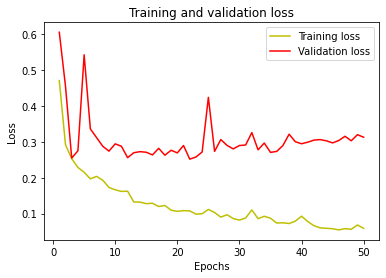

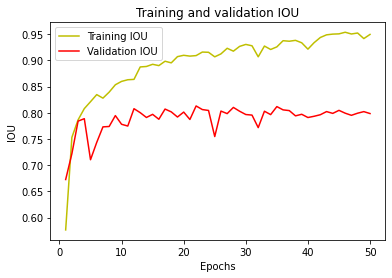

In [18]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

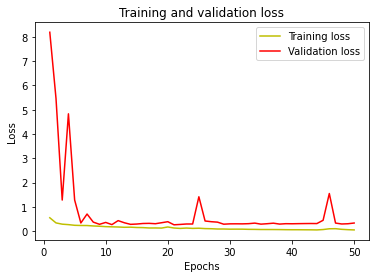

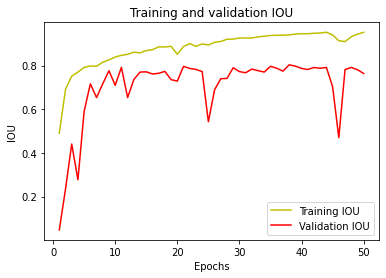

In [19]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

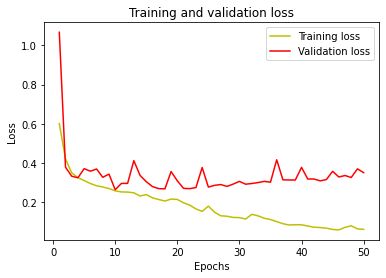

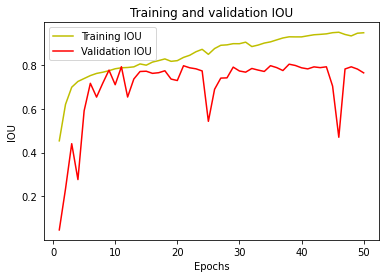

In [20]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

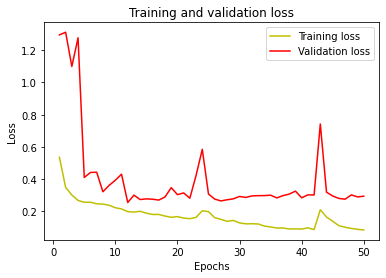

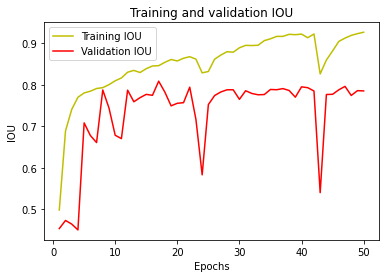

In [21]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history4.history['iou_score']
val_acc = history4.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [23]:
model2.save(cellseg_dir + 'model/full/inceptionv3_backbone_50epochs.hdf5')
model3.save(cellseg_dir + 'model/full/vgg19_backbone_50epochs.hdf5')
model4.save(cellseg_dir + 'model/full/densenet201_backbone_50epochs.hdf5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Mean IoU = 0.8035077
[[4421289.   93255.]
 [ 102840.  363352.]]


TypeError: ignored

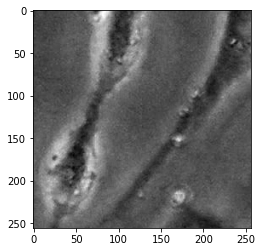

In [26]:





#####################################################

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
#model1 = load_model('saved_models/_backbone_50epochs.hdf5', compile=False)
#model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
#model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
##############################################################

#Test some random images
# import random
# test_img_number = random.randint(0, len(X_test2))
# test_img = X_test2[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_input=np.expand_dims(test_img, 0)

# test_img_input1 = preprocess_input2(test_img_input)

# test_pred1 = model2.predict(test_img_input1)
# test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(test_prediction1, cmap='gray')
# plt.show()